# Human Diffusion

### A Q-Learning Process About The Human Migration From Africa

We start by importing the proper modules (equivalent to libraries in R).

These are

- NumPy
- MatPlotLib
- Pandas
- PIL, (Pillow) an image handler
- tqdm, (pronounced ta-qa-dum) from Arabic (taqadum, تقدّم) meaning *progress*, is a simple progress bar to be able to estimate the time for each task



In [1]:
#pip install -r requirements.txt

In [2]:
from earth import Earth

## Generating the Map
We initialise the picture that we want to use, and convert it into pixel values, so we can have a pure black and white image of the earth to use.

In [3]:
stage = Earth()

The following forloop checks each individual pixel and the converts it to black or white. The threshold was found through running the loop many times and picking a number that looked good enough.

In [4]:
stage.black_and_white('earth.jpg', 'newPixels.csv', 'pure-bw-earth.jpg')

100%|████████████████████████████████| 450632/450632 [00:00<00:00, 3755800.06it/s]


We then generate the new picture and save it before we convert it into an array.

In [5]:
stage.generate_image('pure-bw-earth.jpg')

100%|█████████████████████████████████████████| 619/619 [00:00<00:00, 1172.81it/s]


We are now ready to create the map we will need.

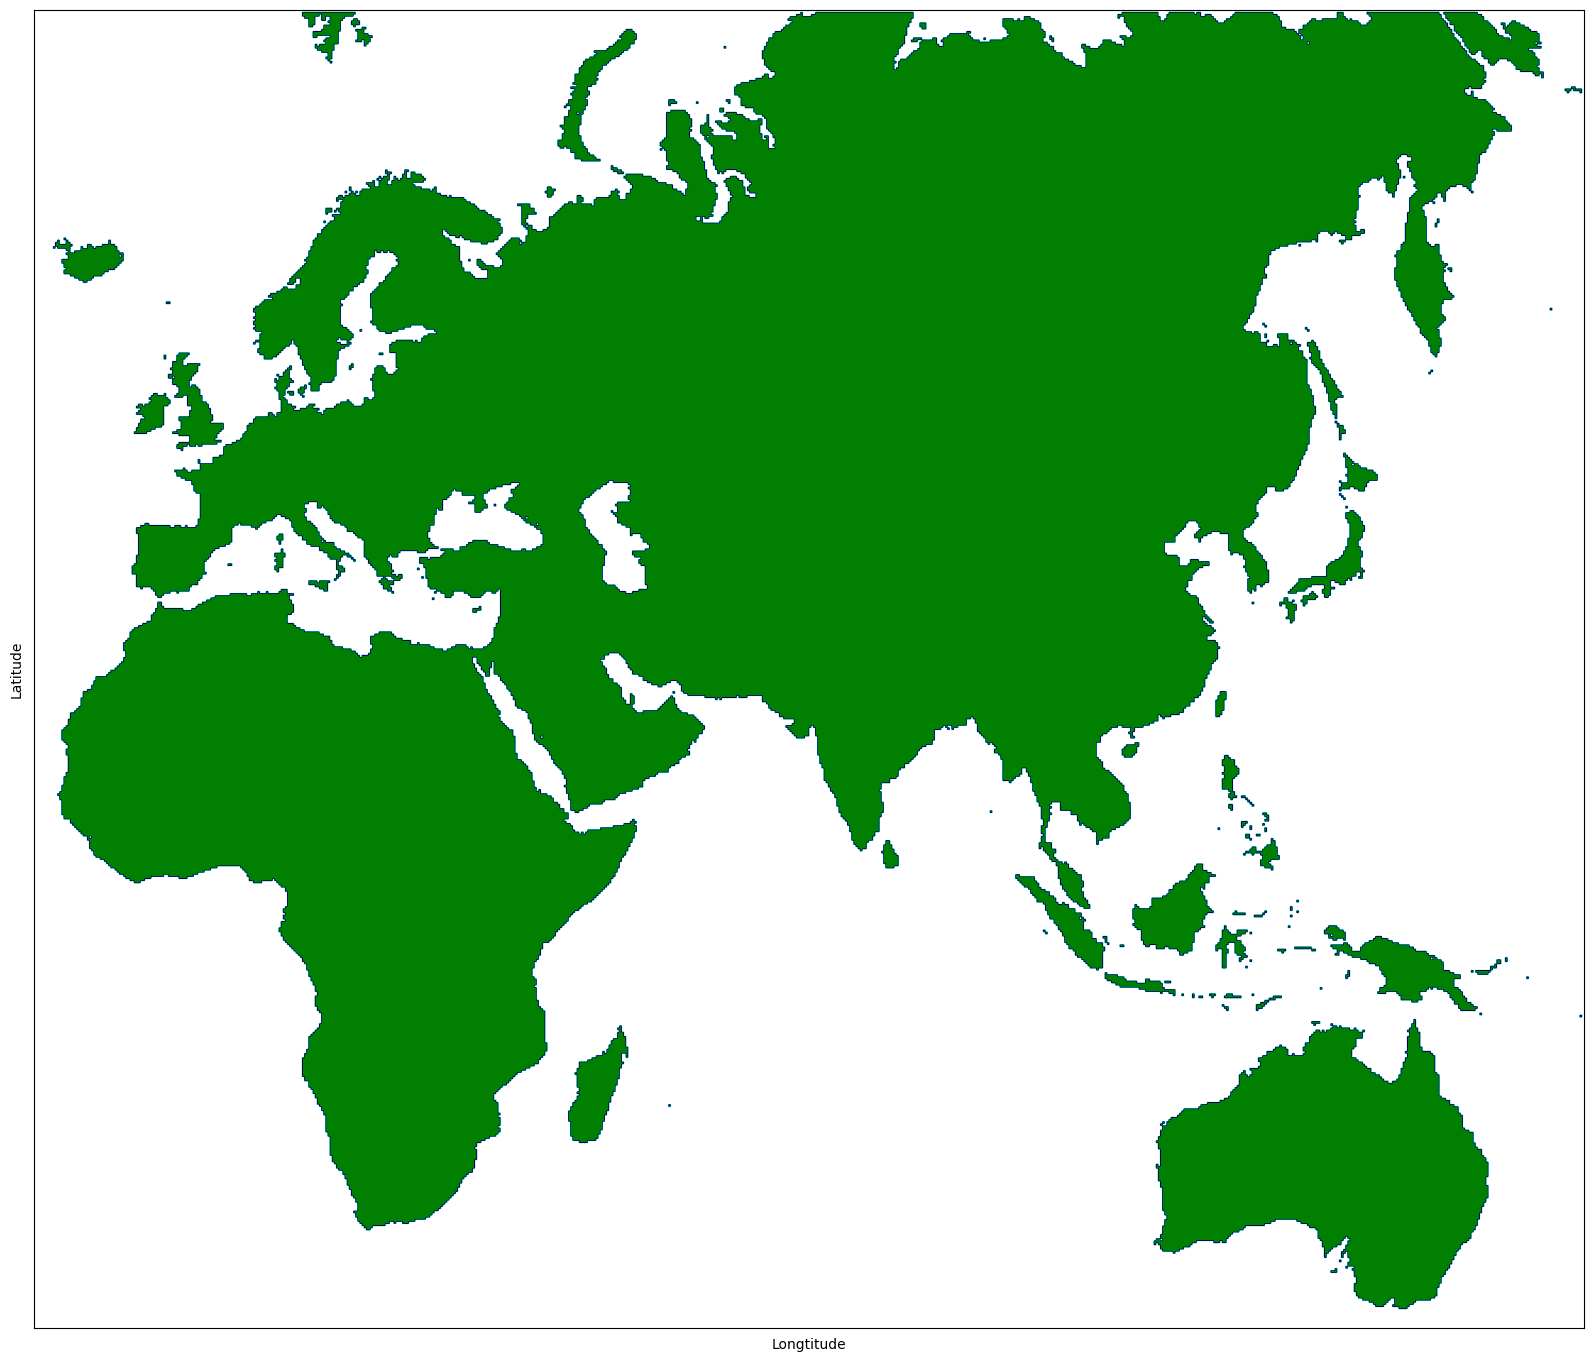

In [6]:
stage.plot('map.jpg')

Now that we have our map ready, we can move on to the implementation of the algorithm.

## Application of the Q-Learning Algorithm

We import the necessary libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(1)

and define the actions that the agent is able to perform

In [8]:
actions = ['west', 'east', 'north', 'south']
#coded to 0, 1, 2, 3

Then we can generate the Q-map, which gives the rewards.

In [9]:
q_values = np.random.uniform(-1, 1, size=(stage.height,stage.width, len(actions)))

After, we define the functions that we will use, namely tone to generate our starting position, one for the agent to take action either randomly or by checking the Q-table, and one to define the result of the action taken.

In [10]:
def starting_area(column, row):
    col = np.random.randint(column[0], column[1])
    row = np.random.randint(row[0], row[1])
    return col, row
    
    
def next_action(current_height, current_width, epsilon):
    if np.random.random() < epsilon:
        move = np.argmax(q_values[current_height, current_width])
    else:
        move = np.random.randint(4)
    return move
    
    
def next_location(height, width, action):
    new_width = width
    new_height = height
    
    if actions[action] == 'west' and width > -1:
        new_width = width - 1
            
    if actions[action] == 'east' and width < stage.width - 1:
        new_width = width + 1
            
    if actions[action] == 'north' and height > 1:
        new_height = height -1
    
    if actions[action] == 'south' and height < stage.height:
        new_height = height +1
        
   
    return new_height, new_width
            

Now we are ready to run the algorithm for the number of episodes we need

100%|█████████████████████████████████████| 200000/200000 [51:49<00:00, 64.32it/s]


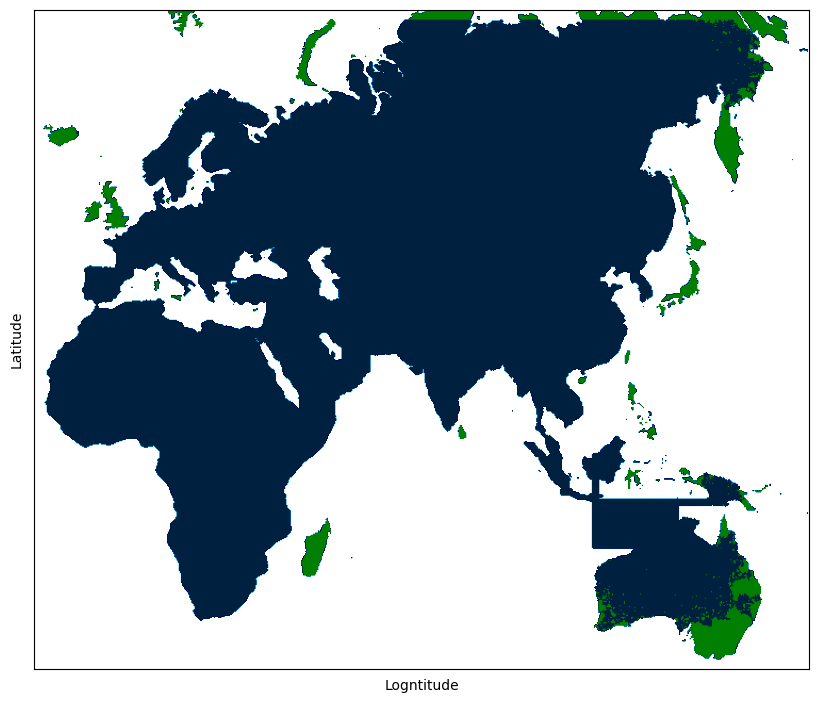

In [11]:
reward_map = np.zeros(shape=(stage.height,stage.width))
reward_map[np.where(stage.map > 0)] = -10
reward_map[:10, :] = -15
reward_map[610:, :] = -15
reward_map[:, 720:] = -15
reward_map[:, :10] = -15

#Arabian bridge
    # Gulf of Aden
reward_map[350:388, 250:282] = 0
    # Hormuz
reward_map[300:340, 290:315] = 0

# Indonesian bridge
    # Sumatra
reward_map[417:433, 485:495] = 0
    # Java
reward_map[450:455, 495:505] = 0
    # Brunei
reward_map[430:465, 525:530] = 0
    # New Guinea
reward_map[460:465, 525:645] = 0
    # Australia
reward_map[460:505, 525:605] = 0



# Bering Straight
reward_map[30:60, 580:610] = 50
# Australia
reward_map[510:540, 580:610] = 50

real_map = np.ones(shape=(stage.height,stage.width))*10
real_map[np.where(stage.map > 0)] = -10

timeline = np.arange(0, 5000)
episodes = np.arange(0, 200000)

reward_per_episode = np.zeros(len(episodes))
lifetime = np.zeros(len(episodes))
ims = []
for episode in tqdm(episodes): #30k

    epsilon = 0.7
    discount_factor = 0.3
    learning_rate = 1

    rewards = np.zeros(len(timeline))
    
    if episode >= 195000: # This statement is the way we destabilise the system to get more natural motion
    
    # India
        reward_map[390, 388] = 20      
    # New Guinea Papua
        reward_map[455, 650] = 20
    # Brunei
        reward_map[425, 540] = 20
    #Australia
        reward_map[510:540, 580:610] = 50


    old_height, old_width = 400, 230
    height, width = starting_area([old_height-5, old_height+5], [old_width-5, old_width+5])

    for year in timeline:
        try:

            action = next_action(height, width, epsilon)
            old_height, old_width = height, width
            height, width = next_location(height, width, action)

            reward = reward_map[height, width]
            rewards[year] = reward

            old_q_value = q_values[old_height, old_width, action]
            temporal_difference = reward + (discount_factor*np.max(q_values[height, width])) - old_q_value

            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_height, old_width, action] = new_q_value                

            if reward_map[old_height, old_width] > 0:
                reward_map[old_height, old_width] = 0

            real_map[old_height, old_width] = 5

        except IndexError as e:
            break

        if year == timeline[-1]:
            lifetime[episode] = year

        if reward_map[old_height, old_width] <= -10 and reward_map[height, width] <= -10:
            lifetime[episode] = year
            break            

    reward_per_episode[episode] = np.mean(rewards)
    if reward_map[510:540, 580:610].all() == 0:
        #Australia
        reward_map[510:540, 580:610] = 50
            
    if reward_map[30:60, 580:610].all() == 0:
        # Bering Straight
        reward_map[30:60, 580:610] = 50


        

plt.figure(figsize = (10,10))
plt.ylabel('Latitude')
plt.xlabel('Logntitude')
plt.xticks([])
plt.yticks([])
plt.imshow(real_map, cmap = 'ocean_r')
plt.show()

Below is a graph to show the average score of the algorithm over the number of episodes (averaged over several episodes for clarity), as well as the survival time of the agent in each episode. This was used to understand the optimisation the algorithm has reached at a certain range of episodes, since once it is optimised, there is a sharp drop (I don't know why).

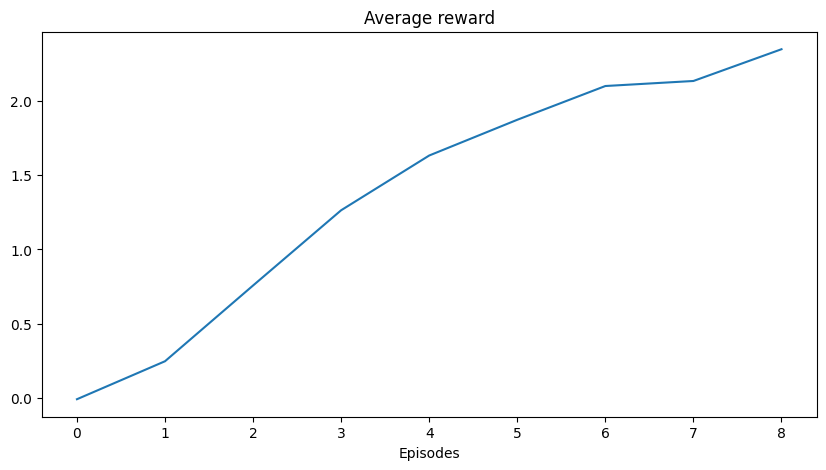

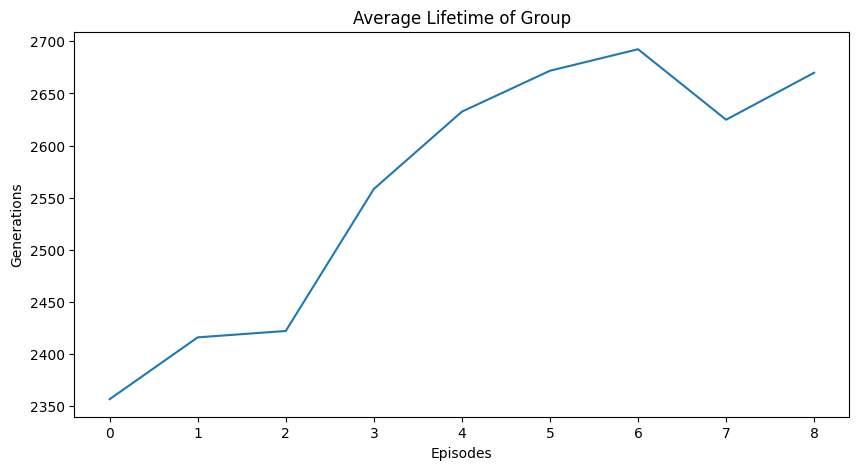

In [12]:
avg_reward=np.array([])
avg_life = np.array([])
pp = int(len(episodes)/10)

for i in np.arange(len(episodes)):
    if i%pp == 0 and i > 0:
        avg_reward = np.append(avg_reward, np.mean(reward_per_episode[i-pp:i]))
        avg_life = np.append(avg_life, np.mean(lifetime[i-pp:i]))
plt.figure(figsize=(10,5))
plt.title("Average reward")
plt.xlabel('Episodes')
plt.plot(avg_reward)

plt.show()


plt.figure(figsize=(10,5))
plt.title("Average Lifetime of Group")
plt.xlabel('Episodes')
plt.ylabel('Generations')
plt.plot(avg_life)
plt.show()

Finally we run the code once to get a graph, or to see how a singular agent behaves after the amount of episodes we trained it for.

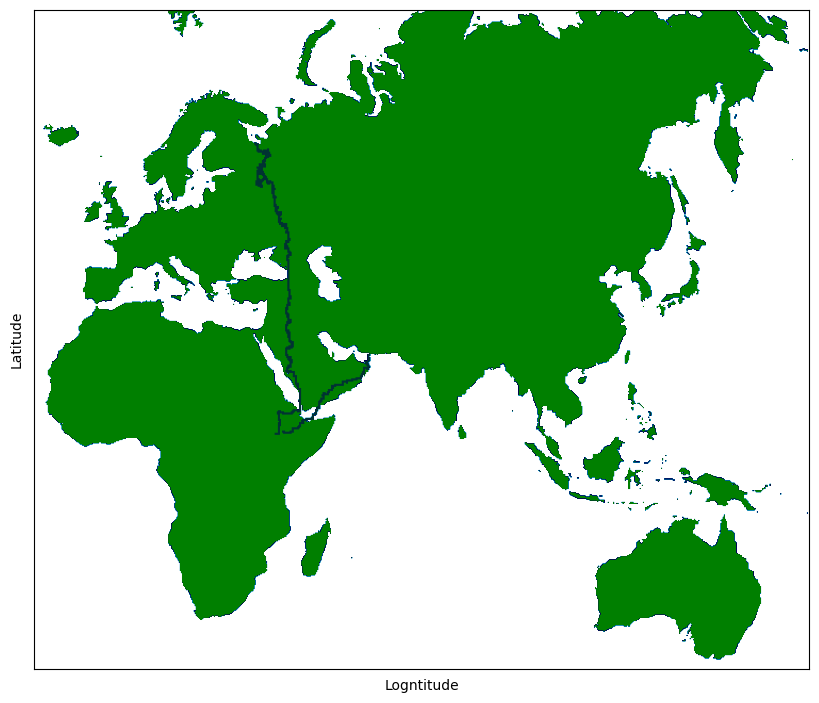

In [13]:
real_map = np.ones(shape=(stage.height,stage.width))*15
real_map[np.where(stage.map > 0)] = -10

timeline = np.arange(0, 4000)

epsilon = 0.7
discount_factor = 0.7
learning_rate = 0

rewards = np.zeros(len(timeline))
#Arabian bridge
reward_map[350:388, 250:282] = 0
reward_map[300:340, 290:315] = 0

#Iran
reward_map[315, 340] = 5

#India
reward_map[388, 392] = 20
reward_map[330, 440] = 40

#Siamese bridge
reward_map[370, 480] = 60
reward_map[370:425, 475:495] = 0

#Indonesian bridge
reward_map[430, 485] = 80
reward_map[430:500, 500:680] = 0
reward_map[450, 505] = 90

# New Guinea Papua
reward_map[455, 650] = 20

# Brunei
reward_map[425, 540] = 20


#Australia
reward_map[510:540, 580:610] = 100

old_height, old_width = 400, 230
height, width = starting_area([old_height-5, old_height+5], [old_width-5, old_width+5])

for year in timeline:
    try:

        action = next_action(height, width, epsilon)
        old_height, old_width = height, width
        height, width = next_location(height, width, action)

        reward = reward_map[height, width]
        rewards[year] = reward

        old_q_value = q_values[old_height, old_width, action]
        temporal_difference = reward + (discount_factor*np.max(q_values[height, width])) - old_q_value

        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_height, old_width, action] = new_q_value                

        if reward_map[old_height, old_width] > 0 and reward_map[old_height, old_width] < 100 :
            reward_map[old_height, old_width] = -1

        real_map[old_height-1:old_height+1, old_width-1:old_width+1] = 10

    except IndexError as e:
        break

    if reward_map[old_height, old_width] <= -10 and reward_map[height, width] <= -10:
        break            

plt.figure(figsize = (10,10))
plt.ylabel('Latitude')
plt.xlabel('Logntitude')
plt.xticks([])
plt.yticks([])
plt.imshow(real_map, cmap = 'ocean_r')
plt.show()